# Quickstart: Random Variables in ProbNum

This tutorial illustrates some basic usage and manipulation of *random variables* in ProbNum. 

Random variables play a central role in ProbNum as they are the primary in- and output objects of a probabilistic numerical method. Random variables generalize scalars, multi-dimensional arrays, or matrices by encoding uncertainty about the quantity they represent. One random variable can be transformed into another by applying an arithmetic operation. 

In [1]:
# general imports
# Make inline plots vector graphics instead of raster graphics.
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("pdf", "svg")

# Plotting style
import matplotlib.pyplot as plt
plt.style.use("../../probnum.mplstyle")

## Example 1: Scalar Normal Random Variable

We first look at a simple example: A scalar random variable $X$ described by a univariate Gaussian a.k.a. ["normal" distribution](https://en.wikipedia.org/wiki/Normal_distribution). A univariate normal random variable can be fully described by only 2 quantities: a scalar mean (`mean`) and a scalar variance (`cov`).

We begin by creating the random variable in ProbNum: 

In [2]:
import numpy as np
np.random.seed(42)  # random seed to get same plots.
from probnum import randvars

# Gaussian random variable X is defined by chosing the mean and (co-)variance.
X = randvars.Normal(mean=0, cov=1)
print(X)

<Normal with shape=(), dtype=float64>


### Manipulating a Random Variable: Through Linear Operations

Inside a ProbNum numerical solver, random variables are manipulated and transformed into each other. This allows the algorithm to take one distribution as input, and return a transformed version of it as output. 

For some transformations, it is known analytically how the random variable transforms (this means that the transformation can be done exactly without error). An example are affine transformations of the form $Y = a X + b$, where the normal random variable $X$ is first multiplied by a scalar $a$, and then translated by another scalar $b$. The result is a new random variable $Y$ which, in this particular case, is also normal distributed with a new mean $b$ and variance $a^2$.

In ProbNum, arithmetic operators such as `+` (addition) `-` (subtraction), or `*` (multiplication) are overloaded, and can be applied to random variable objects. Thus, transforming $X$ into $Y$ can simply be written as follows. Keep in mind that not all operations on a random variable will yield an analytic distribution of the new random variable.

In [3]:
a = 2
b = -2

# Arithmetic operations * and + between scalars and random variable.
Y = a * X + b
print(Y)

<Normal with shape=(), dtype=float64>


We observe that $Y$ again is normal distributed, but with a different mean (`mean`) and variance (`cov`) (recall that the mean of $X$ was 0 and the variance was 1):

In [4]:
Y.mean

-2.0

In [5]:
Y.cov

4.0

Finally, we illustrate the two random variables $X$ and $Y$ by plotting their respective [probability density functions](https://en.wikipedia.org/wiki/Probability_density_function) (pdfs) $f_X$ and $f_Y$.

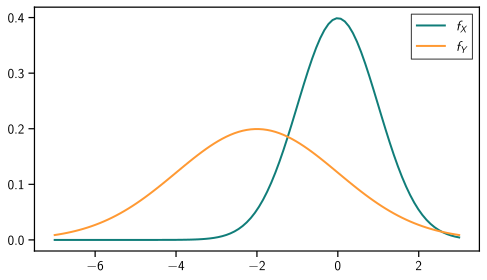

In [6]:
# Plot probability density functions of X and Y.
xx = np.linspace(-7, 3, num=100)
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(xx, X.pdf(xx), label="$f_X$")
axes.plot(xx, Y.pdf(xx), label="$f_Y$")
axes.legend()
plt.show()

## Example 2: Vector-variate Normal Random Variable

We now consider a *vector-variate* random variable described by a multivariate [Gaussian distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). Instead of two scalars, a vector-variate normal random variable can be fully described by a mean vector (`mean`) and a square positive definite covariance-matrix (`cov`).

Again, we begin by creating the random variable in ProbNum. 


In [7]:
# Two-dimensional Gaussian random variable X is defined by chosing the mean vector and covariance matrix.
X = randvars.Normal(mean=np.array([1, 2]), cov=np.array([[5, 0], [0, 2]]))
print(X)

<Normal with shape=(2,), dtype=float64>


### Manipulating a Vector-variate Random Variable: Through Linear Operations

Analogous to above, we can apply an affine transformation to $X$ and create a new normal random variable $Y = AX + b$. This time, the transformation is defined by a matrix $A$ and a vector $b$.

Using the ProbNum arithmetic operators, we can write the transformation as follows. Since we describe a matrix-vector multiplication $AX$ instead of a scalar multiplication this time, we use the matrix-multiplication operator `@`.


In [8]:
# Define the affine transformation by defining the matrix A and the vector b.
A = - np.array([[1, 2], [3, 2]])
b = np.array([1, 2])

# Affine transformation of random variable X.
Y = A @ X + b
print(Y)

<Normal with shape=(2,), dtype=float64>


The vector-variate random variable $Y$ is again normal distributed. We can also print its mean vector and covariance matrix.

In [9]:
Y.mean

array([-4., -5.])

In [10]:
Y.cov

array([[13., 23.],
       [23., 53.]])

Finally, we illustrate the two random variables $X$ and $Y$ again by plotting their respective probability density functions (pdfs) $f_X$ and $f_Y$. The pdfs are shown as two-dimensional contour plots this time, as $X$ and $Y$ are two-dimensional random variables.

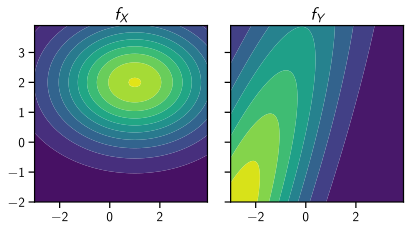

In [11]:
# Contour plot of the probability density functions of X and Y
delta = 0.1
uu = np.arange(-3, 4, delta)
vv = np.arange(-2, 4, delta)
U, V = np.meshgrid(uu, vv)

rvdict = {"$f_X$": X, "$f_Y$": Y}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3.5), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].contourf(U, V, rv.pdf(np.dstack((U, V))), levels=10)
    axes[i].title.set_text(title)
plt.tight_layout()
plt.show()

### Applying ProbNum's Linear Operators

In the example above, we used `numpy.ndarray`s to construct the matrix $A$ that defines the linear transformation $Y=AX$. In ProbNum we also have access to `LinearOperator` which offers a memory-efficient lazy implementation of matrix-vector multiplication.

The ProbNum linear operator can then be used with the same syntax as above. 

In [12]:
from probnum.linops import aslinop

# Define the matrix A in Y=Ax as ProbNum's linear operator.
A = aslinop(np.array([[1, 2], [2, 4], [-1, 0]]))
print(A)

<Matrix with shape=(3, 2) and dtype=int64>


In [13]:
# Linear transformation of random variable X.
Y = A @ X

# Broadcasting.
Y = Y + 1
print(Y)

<Normal with shape=(3,), dtype=float64>


In [14]:
Y.mean

array([ 6., 11.,  0.])

In [15]:
Y.cov

array([[ 13.,  26.,  -5.],
       [ 26.,  52., -10.],
       [ -5., -10.,   5.]])

This time, the matrix $A$ was of shape (3, 2), hence we projected the two-dimensional random variable $X$ into three-dimensional space, and the resulting $Y$ is a three-dimensional random variable. The random samples in the 3D plot below illustrate the density function of $Y$.

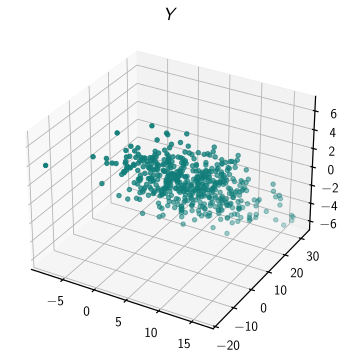

In [16]:
from mpl_toolkits.mplot3d import Axes3D

samples = Y.sample(500)

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2])
ax.title.set_text("$Y$")

## Example 3: Matrix-variate Normal Random Variables

As a third example, we consider a *matrix-variate* random variable described by a [matrix Gaussian distribution](https://en.wikipedia.org/wiki/Matrix_normal_distribution). The distribution has the property, that if the matrix random variable $X$ is vectorized, the covariance matrix of the resulting vector-variate normal distribution has Kronecker structure:

$$
\vec{X} \sim \mathcal{N}(\vec{M}, V \otimes W).
$$
 
The distribution is fully identified by a mean matrix $M$, and the two matrices $V$ and $W$ constituting the covariance matrix $V \otimes W$.

Matrix-variate random variables arise for example in the case of dependent data tabulated in the form of a matrix. In the probabilistic numerics context they arise for example when the inverse of a linear operator is inferred. 



Again, we create the random variable in ProbNum.


In [17]:
from probnum.linops import Kronecker
np.random.seed(1)  # to get same plots when we sample from the matrix-variate distribution

ndim = 10  # dimensionaly of matrix, i.e., X has shape (ndim, ndim)

# Define the mean matrix M
mean = np.vander(x=np.linspace(1, 0.1, ndim), N=ndim, increasing=True)

# Define the Kronecker covariance matrix 
V = 0.1 * np.eye(ndim)
W = 0.1 * np.eye(ndim)
cov = Kronecker(A=V, B=W)

# matrix-variate Gaussian random variable X 
X = randvars.Normal(mean=mean, cov=cov)
print(X)

<Normal with shape=(10, 10), dtype=float64>


To illustrate the matrix-variate random variable, we sample from its distribution and plot the mean matrix $M$ as well as 3 samples. The mean $M$ as well as the samples are matrices themselves of shape 10x10.

In [18]:
# Draw samples
Xsamples = X.sample(3)
print(Xsamples.shape)

(3, 10, 10)


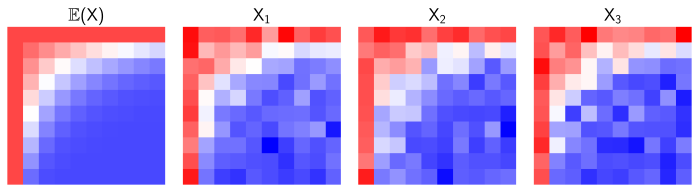

In [19]:
# Plot mean matrix M and 3 samples X1, X2 and X3.
rvdict = {
    "$\mathbb{E}(\mathsf{X})$": X.mean,
    "$\mathsf{X}_1$": Xsamples[0],
    "$\mathsf{X}_2$": Xsamples[1],
    "$\mathsf{X}_3$": Xsamples[2],
}
vmin = np.min([np.min(mat) for mat in list(rvdict.values())])
vmax = np.max([np.max(mat) for mat in list(rvdict.values())])

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, vmin=vmin, vmax=vmax, cmap="bwr")
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

### A Closer Look at the Kronecker Covariance
We will now take a closer look at the covariance matrix $V\otimes W$. By definition of the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product), The matrix $V$ encodes the covariance among rows of $X$, and $W$ the covariance of the columns. 

Below, we construct $W$ such that the columns are independent ($W$ is the identity matrix), and $V$ such that the rows correlate stronger, the closer their index is.

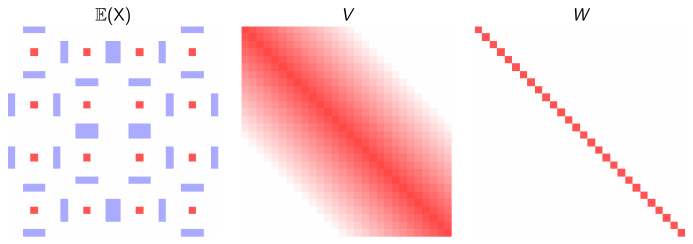

In [20]:
from scipy.sparse import diags

# Recursively structured mean matrix
def recursive_block_mat(k):
    if k == 0:
        arr = np.zeros((7, 7))
        arr[3, 3] = 1
        arr[6, 2:5] = arr[0, 2:5] = - 0.5
        return arr
    else:
        bl = recursive_block_mat(k - 1)
        return np.block([[bl.T, bl  ],
                         [bl  , bl.T]])
    
mean = recursive_block_mat(2)

# Kronecker covariance
n = mean.shape[0]
k = int(n/2)
V = 1 / k * diags(np.concatenate([np.arange(1, k + 1), np.arange(k + 1, 0, step=-1)]), 
                  np.arange(-k, k + 1), shape=(n, n)).toarray()  # row covariance
W = np.eye(n)  # column covariance
cov = Kronecker(V, W)

# Plot parameters
matdict = {"$\mathbb{E}(\mathsf{X})$" : mean, "$V$" : V, "$W$" : W}
vmax = 1.5

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), sharey=True)
for i, (title, rv) in enumerate(matdict.items()):
    axes[i].imshow(rv, cmap='bwr', vmin=-vmax, vmax=vmax)
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

We now draw $N=100$ samples from the distribution of $X$ and plot the empirical mean of the samples $\frac{1}{N}\sum_{i=1}^N X_i$, as well as 3 of the samples $X_i$, $i=1,\dots 3$.

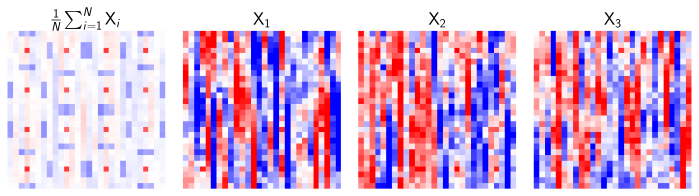

In [21]:
# Define random variable and draw samples
X = randvars.Normal(mean=mean, cov=cov)
N = 100
Xsamples = X.sample(N)

# Plot samples
rvdict = {
    "$\\frac{{1}}{{N}} \sum_{i=1}^N \mathsf{X}_i$": np.mean(Xsamples, axis=0),
    "$\mathsf{X}_1$": Xsamples[0],
    "$\mathsf{X}_2$": Xsamples[1],
    "$\mathsf{X}_3$": Xsamples[2],
}

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, cmap="bwr", vmin=-vmax, vmax=vmax)
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

We can see how the banded structure in $V$ induces samples with similar rows within a certain range given by the width of the band, while the columns do not seem to correlate.